<a href="https://colab.research.google.com/github/corin2202/Landslide-machine-learning/blob/main/Landslide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download tekbahadurkshetri/landslide4sense

Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
 99% 2.83G/2.85G [00:17<00:00, 239MB/s]
100% 2.85G/2.85G [00:17<00:00, 176MB/s]


In [ ]:
!unzip landslide4sense.zip

Streaming output truncated to the last 5000 lines.
  inflating: TrainData/img/image_3558.h5  
  inflating: TrainData/img/image_3559.h5  
  inflating: TrainData/img/image_356.h5  
  inflating: TrainData/img/image_3560.h5  
  inflating: TrainData/img/image_3561.h5  
  inflating: TrainData/img/image_3562.h5  
  inflating: TrainData/img/image_3563.h5  
  inflating: TrainData/img/image_3564.h5  
  inflating: TrainData/img/image_3565.h5  
  inflating: TrainData/img/image_3566.h5  
  inflating: TrainData/img/image_3567.h5  
  inflating: TrainData/img/image_3568.h5  
  inflating: TrainData/img/image_3569.h5  
  inflating: TrainData/img/image_357.h5  
  inflating: TrainData/img/image_3570.h5  
  inflating: TrainData/img/image_3571.h5  
  inflating: TrainData/img/image_3572.h5  
  inflating: TrainData/img/image_3573.h5  
  inflating: TrainData/img/image_3574.h5  
  inflating: TrainData/img/image_3575.h5  
  inflating: TrainData/img/image_3576.h5  
  inflating: TrainData/img/image_3577.h5  
  inf

['img']
Dataset shape: (128, 128, 14)


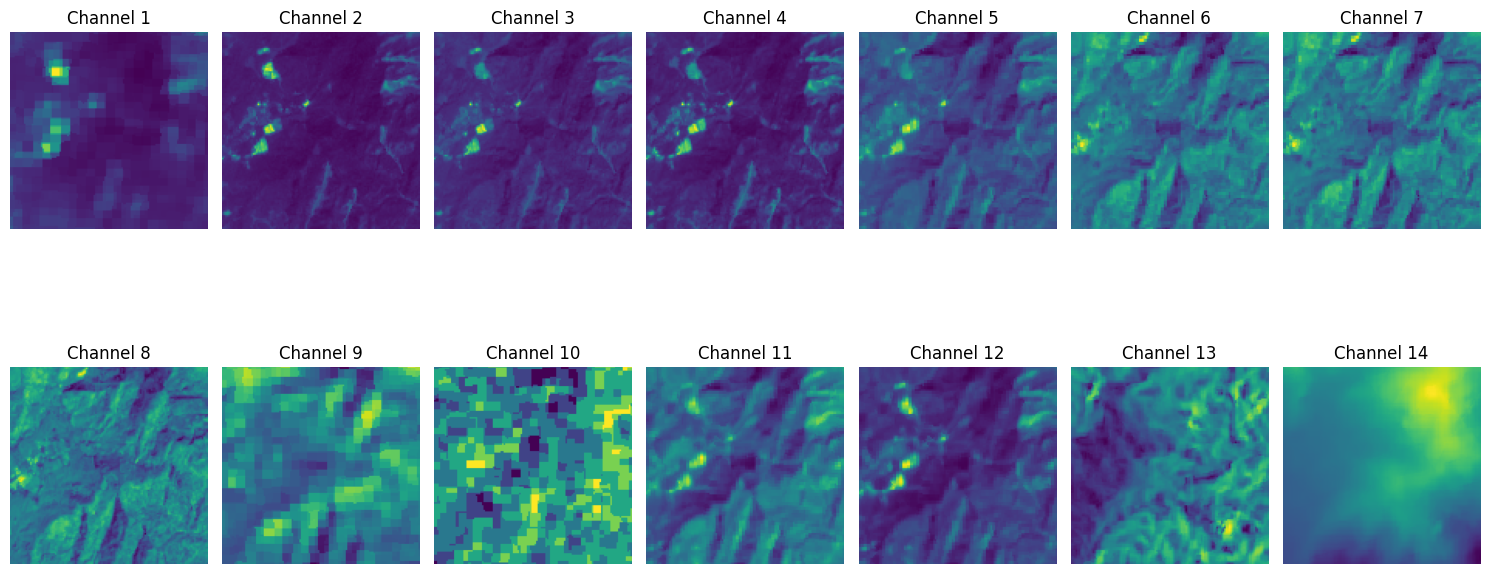

In [ ]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("TrainData/img/image_1.h5", "r+") as f:

    print(list(f.keys()))
    dataset = f["img"]
    print(f"Dataset shape: {dataset.shape}")  # Should be (128, 128, 14)
    fig, ax = plt.subplots(2, 7, figsize=(15, 8))
    for i in range(14):
        row = i // 7
        col = i % 7
        ax[row, col].imshow(dataset[:, :, i], cmap="viridis")
        ax[row, col].set_title(f"Channel {i+1}")
        ax[row, col].axis('off')



    plt.tight_layout()
    plt.show()




['mask']
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


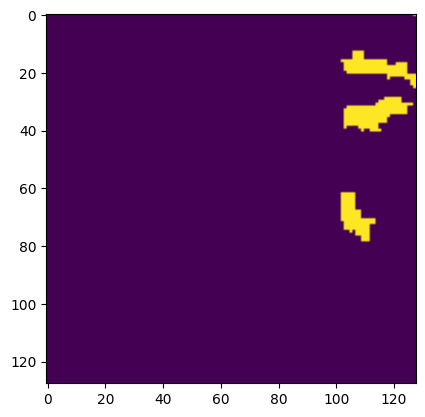

In [ ]:
with h5py.File("TrainData/mask/mask_1.h5","r+") as f:
  print(list(f.keys()))

  dataset = f["mask"]


  plt.imshow(dataset[:,:])
  print(dataset[:,:])


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os

device = "cuda" if torch.cuda.is_available() else "cpu"


class LandslideTrainDataset(Dataset):
  def __init__(self, img_dir, mask_dir, device, transform= None, target_transform = None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.images_list = sorted(os.listdir(self.img_dir))
    self.mask_list = sorted(os.listdir(self.mask_dir))
    self.device = device


  def __len__(self):
    return len(os.listdir(self.mask_dir))

  def __getitem__(self,idx):
    """Returns a tuple of a (128,128,14) tensor containing 14 lots of geospatial data, with a tensor of
    (128,128) which is a mask showing which pixels landslides occured in """

    image_path = os.path.join(self.img_dir,self.images_list[idx])
    mask_path = os.path.join(self.mask_dir,self.mask_list[idx])

    with h5py.File(image_path,"r+") as f1:
      img_np_array = f1["img"]
      img_tensor = torch.from_numpy(img_np_array[:,:,:]).float().to(self.device)

    with h5py.File(mask_path,"r+") as f2:
      mask_np_array = f2["mask"]
      mask_tensor = torch.from_numpy(mask_np_array[:,:]).float().to(self.device)

    img_tensor = img_tensor.permute(2,0,1)

    return img_tensor, mask_tensor



In [ ]:
from torch.utils.data import DataLoader

training_data = LandslideTrainDataset(img_dir = "TrainData/img", mask_dir = "TrainData/mask",device = device)

train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)




In [ ]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.device}")
print(f"Labels batch shape: {train_labels.device}")

Feature batch shape: cuda:0
Labels batch shape: cuda:0


In [ ]:
import torch.nn as nn

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=14, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
def test():
  x = torch.randn((3,14,128,128))
  model = UNET(in_channels = 14, out_channels = 1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)


test()

torch.Size([3, 1, 128, 128])
torch.Size([3, 14, 128, 128])


In [ ]:
for batch_num, (data,targets) in enumerate(train_dataloader):
  print(data.shape)
  print(targets.shape)
  break

torch.Size([32, 14, 128, 128])
torch.Size([32, 128, 128])


In [ ]:
model_1 = UNET(in_channels=14,out_channels = 1).to(device)

In [ ]:
from tqdm import tqdm
epochs = 5



loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters())

for epoch in tqdm(range(epochs)):
  model_1.train()

  train_loss = 0
  for batch_num, (data,targets) in enumerate(train_dataloader):
    data = data.to(device=device)

    targets = targets.float().unsqueeze(1).to(device=device)

    y_logits = model_1(data)
    loss = loss_fn(y_logits,targets)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(train_dataloader)
  print(f"Epoch: {epoch}, Loss: {train_loss}")


 20%|██        | 1/5 [01:21<05:24, 81.02s/it]

Epoch: 0, Loss: 0.161787748336792


 40%|████      | 2/5 [02:34<03:50, 76.68s/it]

Epoch: 1, Loss: 0.053020577877759933


 60%|██████    | 3/5 [03:39<02:22, 71.08s/it]

Epoch: 2, Loss: 0.04147897660732269


 80%|████████  | 4/5 [04:40<01:07, 67.28s/it]

Epoch: 3, Loss: 0.03762225806713104


100%|██████████| 5/5 [05:38<00:00, 67.62s/it]

Epoch: 4, Loss: 0.03562214970588684


(32, 128, 128) (32, 128, 128)


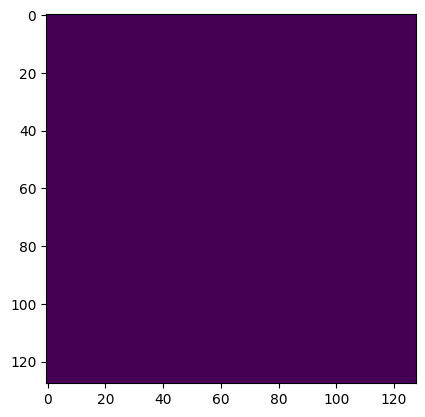

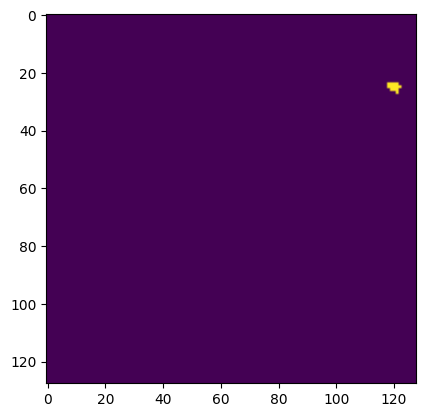

In [ ]:
train_1, label_1 = next(iter(train_dataloader))

model_1.eval()

with torch.inference_mode():
  y_pred = model_1(train_1)
  y_pred = y_pred.squeeze()
  y_pred_sigmoid = torch.sigmoid(y_pred)
  y_pred_binary = (y_pred_sigmoid >= 0.5).float()



np_label = label_1.cpu().numpy()
np_pred = y_pred_binary.cpu().numpy()

print(np_label.shape,np_pred.shape)


plt.imshow(np_label[0])
plt.show()
plt.imshow(np_pred[0])

Calculating f1 score

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.6 MB/s eta 0:00:00


In [ ]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
from torcheval.metrics.functional import binary_f1_score

model_1.eval()
with torch.inference_mode():
    all_preds = []
    all_labels = []
    for X, y in train_dataloader:
        X, y = X.to(device=device), y.to(device=device)

        y_logits = model_1(X).squeeze()
        y_pred = torch.sigmoid(y_logits)
        y_pred = torch.flatten(y_pred)
        y = torch.flatten(y)

        all_preds.append(y_pred)
        all_labels.append(y)


    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)


    f1_score = binary_f1_score(all_preds, all_labels)

print(f"F1 Score: {f1_score}")

F1 Score: 0.7210932970046997
